<a href="https://colab.research.google.com/github/bayesianempirimancer/pyDMBD/blob/main/dmbd_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/bayesianempirimancer/pyDMBD


This is a example of how to use the Dynamic Markov Blanket Discovery algorithm.  The first thing you need is a properly structured data tensor:

    data = torch.randn(T, batch_num, obs_num, obs_dim)

T is the length of the time series
batch_num is the number of batches
obs_num is the number of particles/pixels/locations etc.
obs_dim is the dimension of the observables associated with each 'particle'

For example, in the Newtons cradle example there are 5 particles so obs_num is 5 and each particle has a x and y position and a x and y velocity so obs_dim is 4.  This is put into the input to the DMBD algorithm by letting obs_shape = (5,4).  


We also have to specify the number of latent and role dimension associated with the environment, boundary, and object.  

    role_dims = (8,4,8)
    hidden_dims = (4,2,4)

Optionally you can specify a batch_shape if you want to fit multiple models in parallel, i.e. batch_shape = (10,) to fit 10 models.  

Finally, regression_dim and control_dim can be used when there is a known control signal/driving force to the latent dynamical system or a tensor of regressors that influence the observations directly.  In the absense of regressors or control signals we set these to be either 0 or -1, where -1 indicates that there is no baseline or offset.  I usually set control_dim = 0 and try out both 0 and -1 for the regression_dim.  

In [ ]:

import torch
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from pyDMBD.models.DynamicMarkovBlanketDiscovery import *


# Simulate Newton's Cradle
from pyDMBD.simulations.NewtonsCradle import NewtonsCradle
dmodel = NewtonsCradle(n_balls=5,ball_size=0.2,Tmax=500,batch_size=40,g=1,leak=0.05/8,dt=0.05,include_string=False)
data_0 = dmodel.generate_data('random')[0][0::5]
data_1 = dmodel.generate_data('1 ball object')[0][0::5]
data_2 = dmodel.generate_data('2 ball object')[0][0::5]
data = torch.cat((data_0,data_1,data_2),dim=1)
dy = torch.zeros(2)
dy[1] = 1.0
data = data + dy
v_data = torch.diff(data,dim=0)
v_data = v_data/v_data.std()
data = torch.cat((data[1:],v_data),dim=-1)

# Initialize the model
model = DMBD(obs_shape=data.shape[-2:],role_dims=(8,4,8),hidden_dims=(4,2,4),regression_dim = 0, control_dim=0)




ELBO Calculation is Approximate!!!  Not Guaranteed to increase!!!


Having initialized the model properly, fitting to data is just a matter of calling the update routine.  The first argument is the data while the second two are the regressors and controls.  Since we set control_dim and regression_dim to 0 (or -1) we set these two arguements to None.

    iters controls the number of VB updates
    lr is the learning rate with 1 corresponding to standard coordinate ascent


In [ ]:
model.update(data,None,None,iters=20,latent_iters=1,lr=0.5,verbose=True)


Percent Change in ELBO =  nan    Iteration Time =  5.256718873977661
Percent Change in ELBO =  69.71508264541626    Iteration Time =  6.325960874557495
Percent Change in ELBO =  91.90954566001892    Iteration Time =  5.399759292602539
Percent Change in ELBO =  707.20534324646    Iteration Time =  5.923091650009155
Percent Change in ELBO =  58.82074236869812    Iteration Time =  5.270298719406128
Percent Change in ELBO =  24.26871657371521    Iteration Time =  6.227031707763672
Percent Change in ELBO =  14.767000079154968    Iteration Time =  5.359516859054565
Percent Change in ELBO =  8.530261367559433    Iteration Time =  5.036505699157715
Percent Change in ELBO =  4.06498946249485    Iteration Time =  6.25155782699585
Percent Change in ELBO =  1.9731508567929268    Iteration Time =  5.650781631469727
Percent Change in ELBO =  1.164876390248537    Iteration Time =  7.401098251342773
Percent Change in ELBO =  0.8733685128390789    Iteration Time =  6.105054140090942
Percent Change in E

Now lets plot the output and make a movie!

Show PC scores
Normalized Eigenvalues of s tensor([0.0373, 0.0435, 0.0668, 0.8525])
Normalized Eigenvalues of b tensor([0.3400, 0.6600])
Normalized Eigenvalues of z tensor([0.0114, 0.0152, 0.1837, 0.7897])


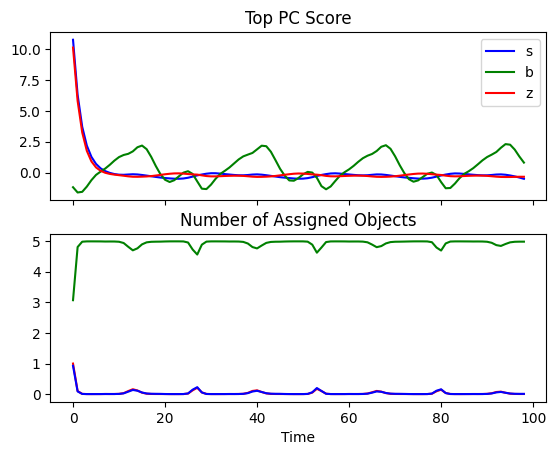

In [ ]:
sbz = model.px.mean().squeeze()

r1 = model.role_dims[0]
r2 = r1+model.role_dims[1]
r3 = r2+ model.role_dims[2]
h1 = model.hidden_dims[0]
h2 = h1+model.hidden_dims[1]
h3 = h2+ model.hidden_dims[2]

batch_num = 50
p = model.assignment_pr()
p = p.sum(-2)
print('Show PC scores')
s = sbz[:,:,0:h1]
s = s-s.mean(0).mean(0)
b = sbz[:,:,h1:h2]
b = b-b.mean(0).mean(0)
z = sbz[:,:,h2:h3]
z = z-z.mean(0).mean(0)

cs = (s.unsqueeze(-1)*s.unsqueeze(-2)).mean(0).mean(0)
cb = (b.unsqueeze(-1)*b.unsqueeze(-2)).mean(0).mean(0)
cz = (z.unsqueeze(-1)*z.unsqueeze(-2)).mean(0).mean(0)

d,v=torch.linalg.eigh(cs)
ss = v.transpose(-2,-1)@s.unsqueeze(-1)
print('Normalized Eigenvalues of s',d/d.sum())
d,v=torch.linalg.eigh(cb)
print('Normalized Eigenvalues of b',d/d.sum())
bb = v.transpose(-2,-1)@b.unsqueeze(-1)
d,v=torch.linalg.eigh(cz)
print('Normalized Eigenvalues of z',d/d.sum())
zz = v.transpose(-2,-1)@z.unsqueeze(-1)

ss = ss.squeeze(-1)[...,-2:]
bb = bb.squeeze(-1)[...,-2:]
zz = zz.squeeze(-1)[...,-2:]

ss = ss/ss.std()
bb = bb/bb.std()
zz = zz/zz.std()

fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(ss[:,batch_num,-1:],'b',label='s')
axs[0].plot(bb[:,batch_num,-1:],'g',label='b')
axs[0].plot(zz[:,batch_num,-1:],'r',label='z')
axs[0].set_title('Top PC Score')
# handles, labels = axs[0].get_legend_handles_labels()
# selected_handles = [handles[0], handles[2], handles[4]]
# selected_labels = [labels[0], labels[2], labels[4]]
# axs[0].legend(selected_handles, selected_labels)
axs[0].legend()

axs[1].plot(p[:,batch_num,0],'r')
axs[1].plot(p[:,batch_num,1],'g')
axs[1].plot(p[:,batch_num,2],'b')
axs[1].set_title('Number of Assigned Objects')
axs[1].set_xlabel('Time')
#plt.savefig('C://Users/brain/Desktop/cradlePCs1.png')
plt.show()


Generating Movie...
Generating Animation using sbz assignments


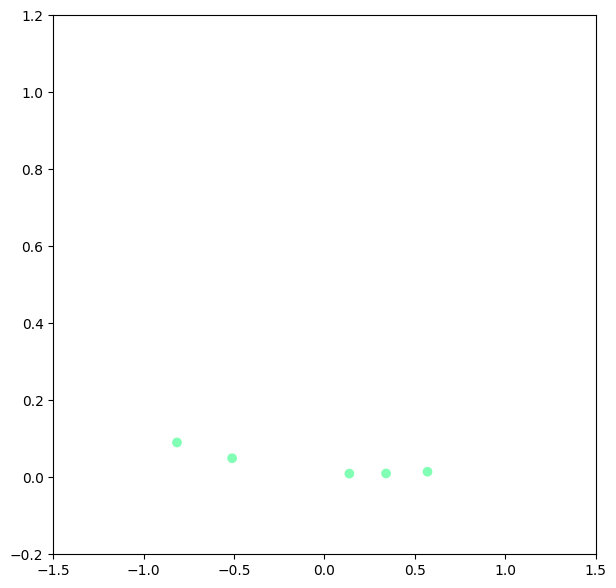

In [ ]:
print('Generating Movie...')
f = r"./cradle.mp4"
ar = animate_results('sbz',f, xlim = (-1.5,1.5), ylim = (-0.2,1.2), fps=10)
ar.make_movie(model, data, (0,40,60,80))#,120))#,60,61,80,81))


The use of a learning rate allows for mini-batching.  This is handled by simply calling the update routine on randomly selected mini-batches with a decreased learning rate.  To stabilize inference of latents before updating parameters we use the latent_iters parameter.  The determines the number of times q(sbz) and q(lambda) are iteratively updated before model parameters are updated.  


In [ ]:
model = DMBD(obs_shape=data.shape[-2:],role_dims=(8,4,8),hidden_dims=(4,2,4),regression_dim = -1, control_dim=0)
minibatch_size = 20
batch_size = data.shape[1]
lr = 0.01*minibatch_size/batch_size
iters = (100*batch_size)//minibatch_size
batch_num = 0
for i in range(iters):
    idx = torch.randint(0,data.shape[1],(minibatch_size,))
    model.update(data[:,idx],None,None,iters=1,latent_iters=5,lr=lr)
    if i%100 == 0:
      sbz=model.px.mean()
      B = model.obs_model.obs_dist.mean()
      if model.regression_dim==0:
          roles = B@sbz
      else:
          roles = B[...,:-1]@sbz + B[...,-1:]
      sbz = sbz.squeeze()
      roles = roles.squeeze()
      idx = model.obs_model.NA/model.obs_model.NA.sum()>0.01

      r1 = model.role_dims[0]
      r2 = r1+model.role_dims[1]
      r3 = r2+ model.role_dims[2]

      pbar = model.obs_model.NA/model.obs_model.NA.sum()
      pbar = pbar/pbar.max()
      p1=model.obs_model.p[:,batch_num,:,list(range(0,r1))].mean(-2)
      p2=model.obs_model.p[:,batch_num,:,list(range(r1,r2))].mean(-2)
      p3=model.obs_model.p[:,batch_num,:,list(range(r2,r3))].mean(-2)

      plt.scatter(roles[:,batch_num,list(range(0,r1)),0],roles[:,batch_num,list(range(0,r1)),1],color='r',alpha=0.25)
      plt.scatter(roles[:,batch_num,list(range(r1,r2)),0],roles[:,batch_num,list(range(r1,r2)),1],color='g',alpha=0.25)
      plt.scatter(roles[:,batch_num,list(range(r2,r3)),0],roles[:,batch_num,list(range(r2,r3)),1],color='b',alpha=0.25)
      plt.xlim(-1.6,1.6)
      plt.ylim(-0.2,1.0)
      plt.show()
    if i%10 == 0:
      print('ELBO = ',model.ELBO())
